## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd

import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

**Пути к директориям и файлам**

In [4]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

PREP_DATASET_PATH = 'course_project_data_prep.csv'

**Загрузка данных**

In [5]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_train.shape

(7500, 17)

**Обзор целевой переменной**

In [7]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [8]:
df_train.iloc[2]

Home Ownership                       Home Mortgage
Annual Income                               751412
Years in current job                       8 years
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                         35
Maximum Open Credit                    1.18243e+06
Number of Credit Problems                        0
Months since last delinquent                   NaN
Bankruptcies                                     0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                      308389
Monthly Debt                                 13651
Credit Score                                   742
Credit Default                                   0
Name: 2, dtype: object

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

**Обзор количественных признаков**

In [10]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор номинативных признаков**

In [11]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Обработка пропусков<a class="anchor" id="gaps"></a>

In [12]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [13]:
df_train['Years in current job'] = df_train['Years in current job'].fillna('10+ years')

In [14]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [15]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [16]:
df_train['Bankruptcies'] = df_train['Bankruptcies'].fillna(0)

In [17]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [18]:
df_train['Annual Income'].mode()[0]

969475.0

In [19]:
df_train['Months since last delinquent'] = df_train['Months since last delinquent'].fillna(0)

In [20]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [21]:
df_train['Annual Income'] = df_train['Annual Income'].fillna(df_train['Annual Income'].mode()[0])

In [22]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [23]:
df_train['Credit Score'].mode()[0]

740.0

In [24]:
df_train['Credit Score'] = df_train['Credit Score'].fillna(0)
#df_train['Credit Score'] = df_train['Credit Score'].fillna(df_train['Credit Score'].mode()[0])

In [25]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Обработка выбросов<a class="anchor" id="outliers"></a>

### Построение новых признаков<a class="anchor" id="new_features"></a>

In [26]:
df_train['IS_SHORT_TERM'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)
df_train = df_train.drop(["Term"], axis=1)

In [27]:
#вариант 2
groupby = df_train.groupby("Purpose")
df_temp=groupby["Credit Default"].mean().to_frame()
df_temp.rename(columns={'Credit Default': 'Purpose_mean'}, inplace=True)
df_train = pd.merge(df_train, df_temp, on='Purpose', how='inner')

groupby = df_train.groupby("Years in current job")
df_temp=groupby["Credit Default"].mean().to_frame()
df_temp.rename(columns={'Credit Default': 'Years in current job_mean'}, inplace=True)
df_temp
df_train = pd.merge(df_train, df_temp, on='Years in current job', how='inner')

groupby = df_train.groupby("Home Ownership")
df_temp=groupby["Credit Default"].mean().to_frame()
df_temp.rename(columns={'Credit Default': 'Home Ownership_mean'}, inplace=True)
df_train = pd.merge(df_train, df_temp, on='Home Ownership', how='inner')

#вариант 2 с плюшкой
groupby = df_train.groupby("Credit Default")
df_temp=groupby["Credit Score"].mean().to_frame()
df_temp.rename(columns={'Credit Score': 'Credit Score_mean'}, inplace=True)
df_train = pd.merge(df_train, df_temp, on='Credit Default', how='inner')

df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,IS_SHORT_TERM,Purpose_mean,Years in current job_mean,Home Ownership_mean,Credit Score_mean
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,99999999.0,47386.0,7914.0,749.0,0,1,0.278264,0.288938,0.296754,585.49768
1,Own Home,969475.0,10+ years,0.0,12.0,25.0,1216336.0,0.0,61.0,0.0,...,467676.0,818311.0,37530.0,0.0,0,1,0.278264,0.288938,0.296754,585.49768
2,Own Home,1289796.0,10+ years,0.0,11.0,20.5,845548.0,0.0,0.0,0.0,...,99999999.0,640433.0,26549.0,708.0,0,0,0.278264,0.288938,0.296754,585.49768
3,Own Home,833416.0,10+ years,0.0,7.0,9.5,237138.0,0.0,59.0,0.0,...,61402.0,58159.0,3091.0,667.0,0,1,0.278264,0.288938,0.296754,585.49768
4,Own Home,679630.0,10+ years,0.0,12.0,22.4,359876.0,0.0,0.0,0.0,...,112420.0,299307.0,19370.0,706.0,0,1,0.278264,0.288938,0.296754,585.49768


In [28]:
df_train = df_train.drop(["Home Ownership", "Years in current job", "Purpose", "Credit Score"], axis=1)

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Annual Income                   7500 non-null float64
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null float64
Bankruptcies                    7500 non-null float64
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Default                  7500 non-null int64
IS_SHORT_TERM                   7500 non-null int32
Purpose_mean                    7500 non-null float64
Years in current job_mean       7500 non-null float64
Home Ownership_mean             7500 non-null float64
Credit Score_mean               7

### Сохранение обучающего датасета<a class="anchor" id="saving"></a>

In [30]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

**Выделение целевой переменной и групп признаков**

In [31]:
df = pd.read_csv(PREP_DATASET_PATH)

In [32]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

**Корреляция с базовыми признаками**

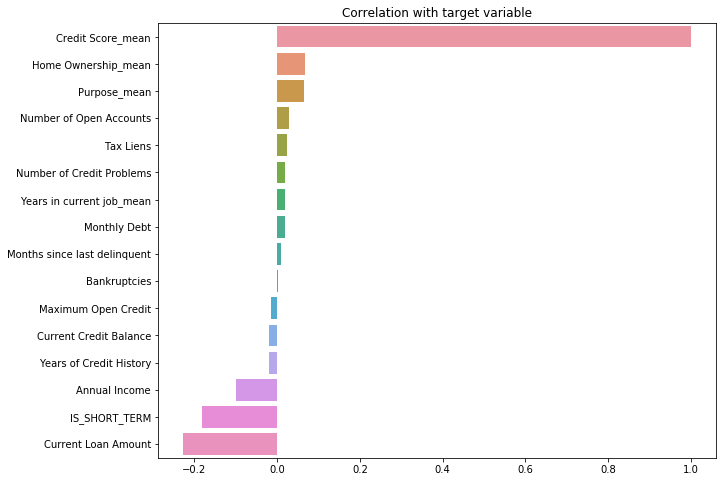

In [33]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

**Матрица корреляций**

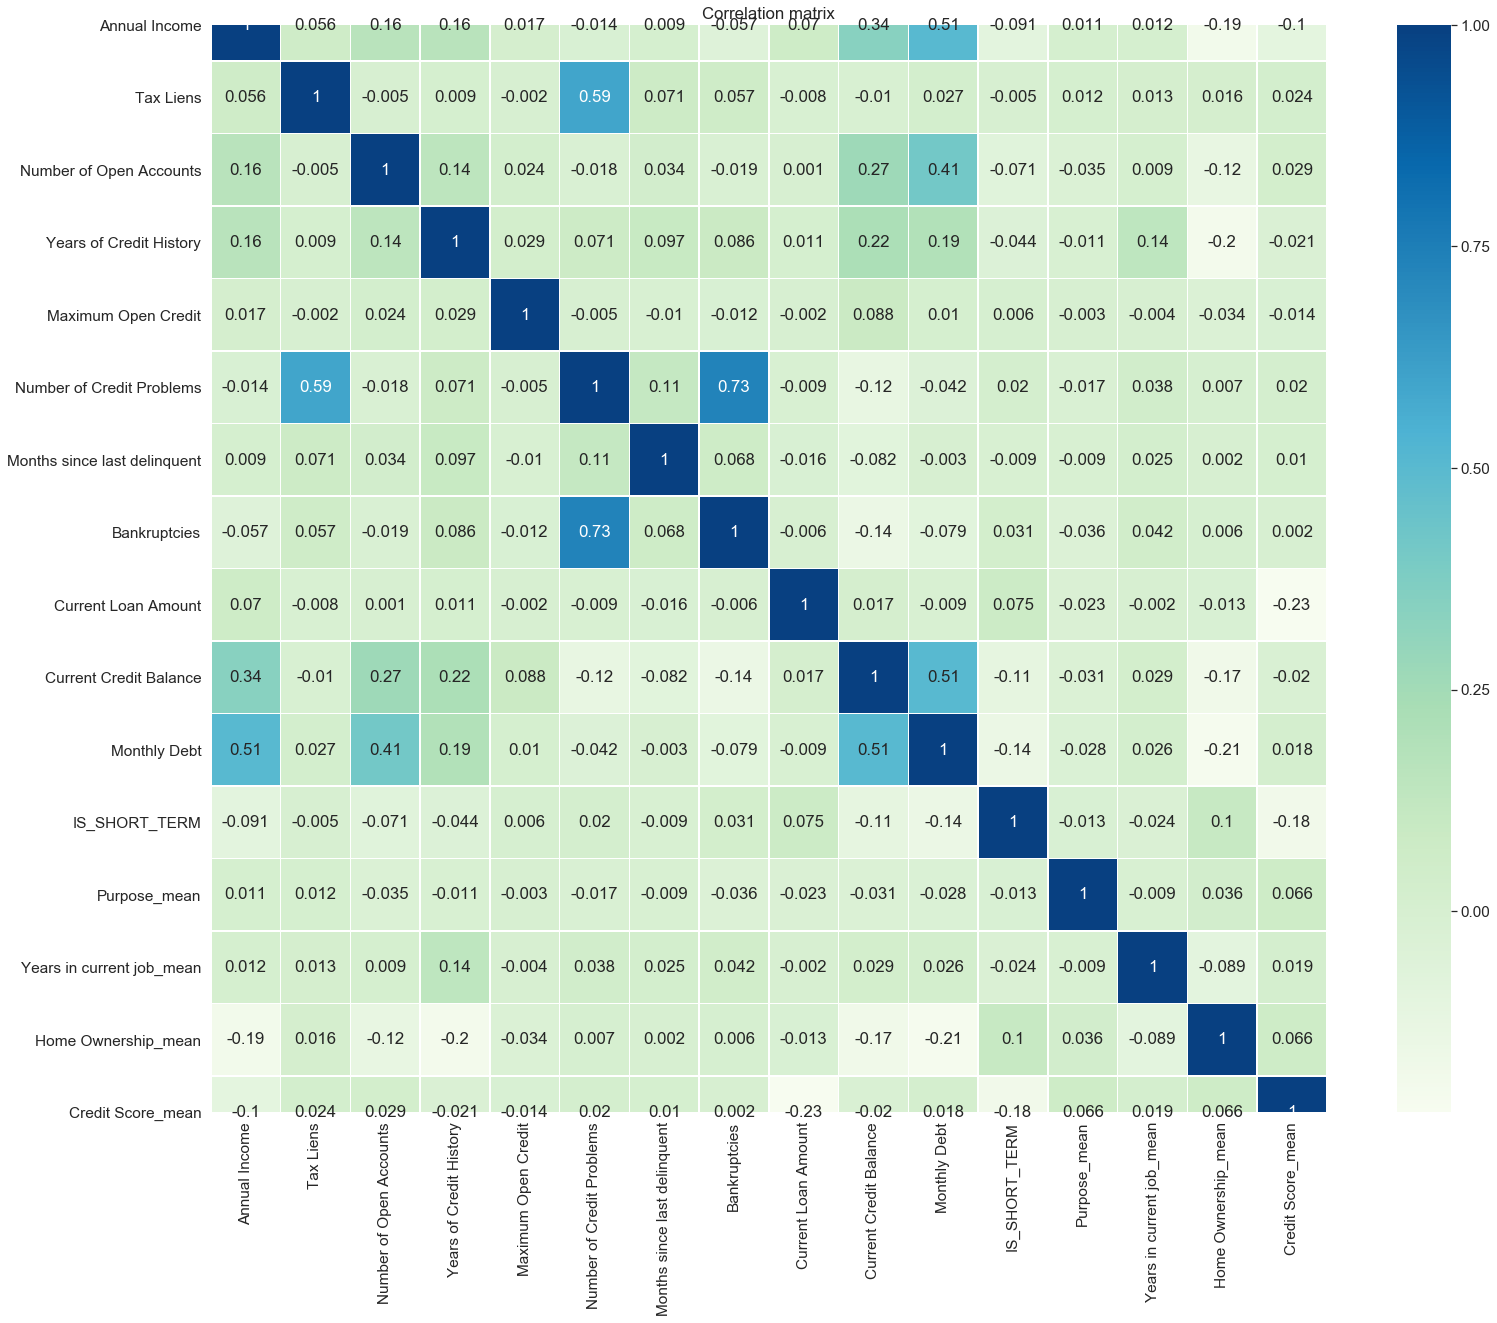

In [34]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Нормализация данных<a class="anchor" id="normalization"></a>

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [35]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [36]:
#вариант 2 с весами
model_lr = LogisticRegression(class_weight={0:1, 1:2.54})

In [37]:
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3743
           1       0.79      0.95      0.86      1507

    accuracy                           0.91      5250
   macro avg       0.88      0.93      0.90      5250
weighted avg       0.92      0.91      0.91      5250

TEST

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1644
           1       0.74      0.96      0.83       606

    accuracy                           0.90      2250
   macro avg       0.86      0.91      0.88      2250
weighted avg       0.92      0.90      0.90      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1436  208
1                 27  579


C:\Users\sych_\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**k ближайших соседей**

In [38]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      3743
           1       0.66      0.44      0.53      1507

    accuracy                           0.78      5250
   macro avg       0.73      0.67      0.69      5250
weighted avg       0.76      0.78      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.75      0.84      0.80      1644
           1       0.37      0.25      0.30       606

    accuracy                           0.68      2250
   macro avg       0.56      0.55      0.55      2250
weighted avg       0.65      0.68      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1387  257
1                456  150


**Случайный лес**

In [39]:
#вариант 1
model_rfc = RandomForestClassifier(random_state=21, class_weight={0:1, 1:2.54})

In [40]:
model_rfc.fit(X_train, y_train)

y_train_pred = model_rfc.predict(X_train)
y_test_pred = model_rfc.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3743
           1       1.00      1.00      1.00      1507

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       1.00      1.00      1.00       606

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1644    0
1                  0  606


C:\Users\sych_\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**Бустинговые алгоритмы**

*XGBoost*

In [41]:
#model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb = xgb.XGBClassifier(random_state=21, class_weights=[1, 2.54])
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[01:51:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3743
           1       1.00      1.00      1.00      1507

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       1.00      1.00      1.00       606

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      22

*LightGBM*

In [42]:
#model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm = lgbm.LGBMClassifier(random_state=21, class_weights=[1, 2.54])
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3743
           1       1.00      1.00      1.00      1507

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       1.00      1.00      1.00       606

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1644    0
1                  0  606


*CatBoost*

In [43]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3743
           1       1.00      1.00      1.00      1507

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       1.00      1.00      1.00       606

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1644    0
1                  0  606


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [44]:
#вариант 1
model = xgb.XGBClassifier(class_weights=[1, 2.54], silent=True, random_state=21)

In [45]:
params = {'n_estimators':[200, 700, 2000, 10000],
          'max_depth':[3, 6, 9]}
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [46]:
%%time

rs = RandomizedSearchCV(model_rfc, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 1min 47s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight={0: 1,
                                                                  1: 2.54},
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_lea

In [47]:
rs.best_params_

{'n_estimators': 700, 'max_depth': 6}

In [48]:
rs.best_score_

1.0

**Обучение и оценка финальной модели**

In [49]:
%%time

final_model = xgb.XGBClassifier(random_state=21, class_weights=[1, 2.54])
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[01:53:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3743
           1       1.00      1.00      1.00      1507

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       1.00      1.00      1.00       606

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      22